In this notebook we will implement a simplified version of the DCM model.

In [1]:
import numpy
import os,sys
%matplotlib inline
import matplotlib.pyplot as plt
sys.path.insert(0,'../utils')
from mkdesign import create_design_singlecondition
import scipy.interpolate
from scipy.integrate import odeint
import math
from nipy.modalities.fmri.hemodynamic_models import spm_hrf,compute_regressor



In [2]:
# first let's build the model without the bilinear influence (aka PPI)
# after http://spm.martinpyka.de/?p=81
nregions=5
z=numpy.zeros(nregions)

# intrinsic connectivity
A=numpy.zeros((z.shape[0],z.shape[0]))
A=numpy.diag(numpy.ones(z.shape[0])*-1)
# add some structure
#A=A + numpy.diag(numpy.ones(z.shape[0]-1),k=-1)
A[2,1]=1
A[3,1]=1
B=numpy.zeros(A.shape)
B[2,0]=1
B[4,0]=1

C=numpy.zeros((z.shape[0],1))
C[0]=1
u=0

print A
print B
print C

# we are assuming a 1 second TR for the resulting data
# but the neural data are at a 1/16 millisecond time resolution
stepsize=.01
tslength=300
timepoints=numpy.arange(0,tslength,stepsize)

# create a blocked design
d,design=create_design_singlecondition(blockiness=1.0,deslength=tslength,blocklength=20,offset=20)

u=scipy.interpolate.griddata(numpy.arange(1,d.shape[0]),d,timepoints,fill_value=0)

def find_nearest(array,value):
    idx = numpy.searchsorted(array, value, side="left")
    if math.fabs(value - array[idx-1]) < math.fabs(value - array[idx]):
        return idx-1
    else:
        return idx

def dcm_model(t,z,A,B,C,u):
    ut=numpy.abs(timepoints - t).argmin() 
    return (A.dot(z)+ u[ut]*B.dot(z) + C.dot(u[ut]).T)[0] 

def mk_dcm_dataset(timepoints,z,noise_sd):
    data=numpy.zeros((len(timepoints),len(z)))
    for i in range(1,len(timepoints)):
        data[i,:]=data[i-1,:] + dcm_model(timepoints[i],data[i-1,:],A,B,C,u)  + numpy.random.randn(len(z))*noise_sd 
    hrf=spm_hrf(stepsize,oversampling=1)
    data_conv=numpy.zeros(data.shape)
    for i in range(len(z)):
        data_conv[:,i]=numpy.convolve(data[:,i],hrf)[:data.shape[0]]        
    return data,data_conv    

[[-1.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.]
 [ 0.  1. -1.  0.  0.]
 [ 0.  1.  0. -1.  0.]
 [ 0.  0.  0.  0. -1.]]
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]]
[[ 1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]


In [3]:
noise_sd=10
data,data_conv=mk_dcm_dataset(timepoints,z,noise_sd)
numpy.save('dcmdata.npy',data_conv)

[[ 1.          0.02950259  0.5688075  -0.03972055  0.6973109 ]
 [ 0.02950259  1.          0.54404822  0.67505005  0.22206299]
 [ 0.5688075   0.54404822  1.          0.32741313  0.65564777]
 [-0.03972055  0.67505005  0.32741313  1.          0.11322704]
 [ 0.6973109   0.22206299  0.65564777  0.11322704  1.        ]]


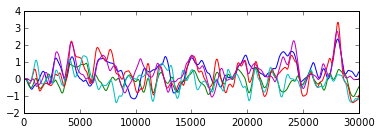

In [4]:
plt.subplot(211)
plt.plot(data_conv)
print numpy.corrcoef(data_conv.T)


In [5]:
from sklearn.covariance import GraphLassoCV
glasso=GraphLassoCV()
glasso.fit(data_conv)
from pcor_from_precision import pcor_from_precision
print pcor_from_precision(glasso.precision_)
print A + B

[[ 0.          0.14405408 -0.28423603  0.05711499 -0.47857248]
 [ 0.14405408  0.         -0.40199156 -0.53364171  0.        ]
 [-0.28423603 -0.40199156  0.         -0.02500345 -0.3718081 ]
 [ 0.05711499 -0.53364171 -0.02500345  0.          0.        ]
 [-0.47857248  0.         -0.3718081   0.          0.        ]]
[[-1.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.]
 [ 1.  1. -1.  0.  0.]
 [ 0.  1.  0. -1.  0.]
 [ 1.  0.  0.  0. -1.]]


In [6]:
def show_graph_with_labels(adjacency_matrix, mylabels):
    import matplotlib.pyplot as plt
    import networkx as nx
    import numpy as np
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    nx.draw(gr, node_size=500, pos=nx.circular_layout(gr),labels=mylabels, with_labels=True)
    plt.show()

KeyError: 0

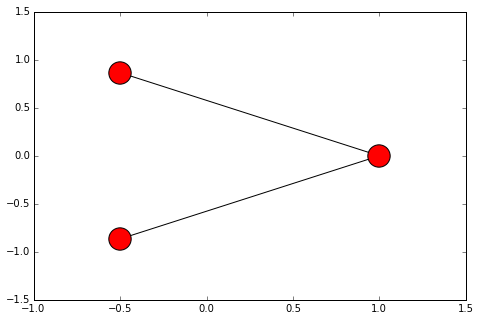

In [7]:
show_graph_with_labels(A,dict((i,'%d'%i) for i in range(len(z))))

look at a single impulse

In [ ]:
timepoints=numpy.arange(0,20,0.01)
u=numpy.zeros(timepoints.shape[0])
u[10:20]=1

zn_single=odeint(dcm_model,z,timepoints,args=(A,B,C,u,sd))

In [ ]:
plt.plot(timepoints,zn_single)

In [ ]:
plt.plot(d)

In [ ]:
timepoints

do it without differential equations, for simplicity